# Hybrid Deep Learning Model: Combining Supervised and Unsupervised Deep Learning Models

## Part 1 - Self Organizing Map


### Install MiniSom and tensorflow packages

In [ ]:
!pip install MiniSom
!pip install tensorflow

### Importing the libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing the dataset

In [4]:
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values

### Feature Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

### Training the SOM

In [6]:
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

### Visualizing the results of the Self Organizing Map

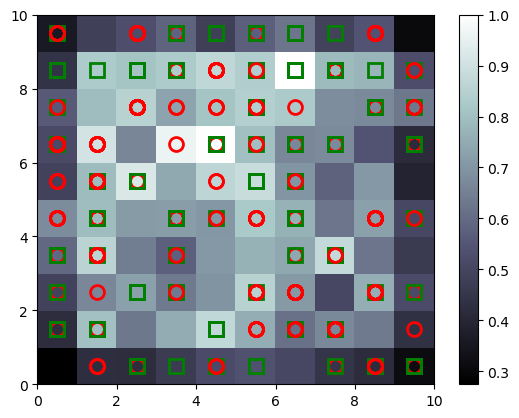

In [7]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

### Finding the frauds

We take the whittest one as this is the one which is closest to 1.0 meaning that the probability of that being the neuron containing the frauds, in this case, that would be the one at (7,9) and the one at (5,6) therefore we select those two and input them below

In [8]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(7,9)], mappings[(5,6)]), axis = 0)
frauds = sc.inverse_transform(frauds)

### Printing the Fraunch Clients

In [9]:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

Fraud Customer IDs
15762716
15567839
15579583
15642336


## Part 2 - Going from Unsupervised to Supervised Deep Learning

To go from unsupervised to supervised DL we need a depending variable, because we need the model to understand the correlation between the features and the results. Later will be shown, that this dependent variable will be called is_fraud, equal to 1 if there is fraud and equal to 0 if there is not.

Create Matrix of Features which contains info for every customer of the bank and includes all the columns except the first one (index 0) as we don not need the customer id to calculate the probability of fraud

In [10]:
customers = dataset.iloc[:, 1:].values

### Create Dependent Variable

This dependent variable will contain the probability of the customer commiting fraud or not. So we will have a binary output (0 or 1). For that we will extract the customer ids from the list of frauds which contains all the customers id from those who potentially committed fraud.

First a vector of zeros of the length of the dataset is initialized, then for each customer check if their customer id belongs to the list of frauds, and if yes then change the value from 0 to 1.

In [11]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1

## Part 3 - Artificial Neural Network

Now we have all the ingredients to train our ANN 

### Feature Scaling

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

### Building the ANN

### Importing the tensorflow libraries and packages

In [14]:
import tensorflow as tf
tf.__version__

'2.15.0'

### Initializing the ANN

In [15]:
ann = tf.keras.models.Sequential()

### Adding the input layer and the first hidden layer

In [16]:
ann.add(tf.keras.layers.Dense(units=2, activation='relu'))

### Adding the output layer

In [17]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

### Compiling the ANN

In [18]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Training the ANN on the Training set ( 3 epochs is enough to reach max accuracy)

In [19]:
ann.fit(customers, is_fraud, batch_size = 1, epochs = 3)

Epoch 1/3
690/690 [==============================] - 1s 936us/step - loss: 0.4838 - accuracy: 0.8493
Epoch 2/3
690/690 [==============================] - 1s 865us/step - loss: 0.2304 - accuracy: 0.9725
Epoch 3/3
690/690 [==============================] - 1s 861us/step - loss: 0.1381 - accuracy: 0.9928


### Predicting test set results

We create a 2D array containing the customer ids and the probability of them commiting fraud and then we sort them according to their probability of cheating (but we only sort the second column, because we only want to sort the probabilities). 

In [20]:
y_pred = ann.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]

22/22 [==============================] - 0s 925us/step


### Set print options to display in decimal form and print results

In [21]:
np.set_printoptions(precision=8, suppress=True)

In [22]:
print(y_pred)

[[15621423.                0.        ]
 [15591010.                0.0000733 ]
 [15776921.                0.00007386]
 ...
 [15638610.                0.3286224 ]
 [15667934.                0.34757027]
 [15605872.                0.3867951 ]]
